# Multi class intent classification using pre-trained BERT

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install simpletransformers

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
DATA_PATH = '/storage/data/intent_classification/'

# Data pre processing

- The train set contains 25 intent classes each having 100 records
- Each class is represented with a number from 0 to 24. Mapping between the numbers to actual class is defined in the intents_map dict below
- Validation set contains 20 records for each class
- We will be taking the first 10 classes to train the model for this initial version

In [4]:
train_df = pd.read_csv(DATA_PATH+'train_enc.csv')
eval_df = pd.read_csv(DATA_PATH+'val_enc.csv')

In [93]:
intents_map = {0:'transfer',
1:'improve_credit_score',
2:'replacement_card_duration',
3:'application_status',
4:'balance',
5:'freeze_account',
6:'transactions',
7:'spending_history',
8:'rewards_balance',
9:'credit_score',
10:'new_card',
11:'report_lost_card',
12:'damaged_card',
13:'bill_due',
14:'exchange_rate',
15:'credit_limit',
16:'account_blocked',
17:'report_fraud',
18:'direct_deposit',
19:'interest_rate',
20:'credit_limit_change',
21:'bill_balance',
22:'order_checks',
23:'card_declined',
24:'expiration_date'}

## Take the first 10 classes for training and validation

In [94]:
NUM_CLASSES = 10
train = None
train_display = None # Just for better visualization experience with string labels instead of numbers
for i in range(NUM_CLASSES):
    train=pd.concat([train,train_df.loc[train_df['labels'] == i]])  
    train_display=pd.concat([train_display,train_df.loc[train_df['labels'] == i]])  

val = None
for i in range(NUM_CLASSES):
    val=pd.concat([val,eval_df.loc[eval_df['labels'] == i]])       

In [95]:
train.shape, train_display.shape


((1000, 2), (1000, 2))

In [7]:
val.shape

(200, 2)

In [101]:
train.head(), train_display.head()

(                                                          text  labels
 0  i need $20000 transferred from my savings to my checking     0     
 1  complete a transaction from savings to checking of $20000    0     
 2  transfer $20000 from my savings account to checking account  0     
 3  take $20000 from savings and put it in checking              0     
 4  put $20000 into my checking account from my savings account  0     ,
                                                           text    labels
 0  i need $20000 transferred from my savings to my checking     transfer
 1  complete a transaction from savings to checking of $20000    transfer
 2  transfer $20000 from my savings account to checking account  transfer
 3  take $20000 from savings and put it in checking              transfer
 4  put $20000 into my checking account from my savings account  transfer)

### Let's look into the selected classes for training

In [99]:
train_display['labels'] = train_display['labels'].apply(intents_map.get)
train_display[['text','labels']].groupby(['labels']).count()

,text
labels,
application_status,100
balance,100
credit_score,100
freeze_account,100
improve_credit_score,100
replacement_card_duration,100
rewards_balance,100
spending_history,100
transactions,100


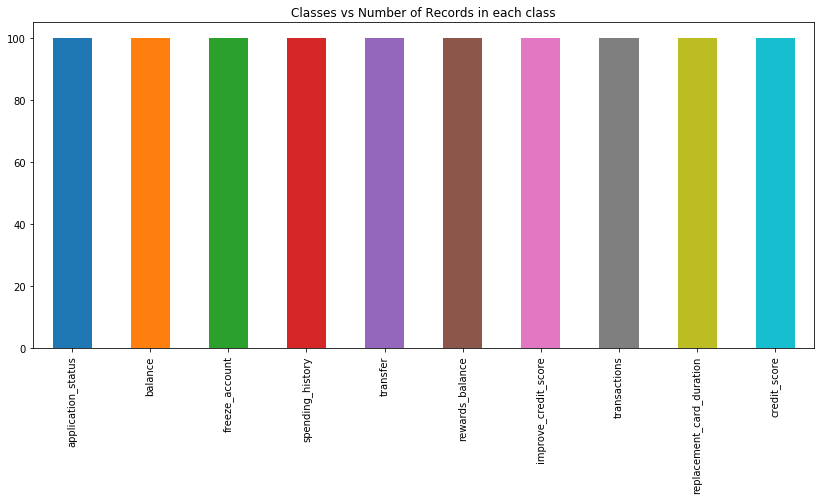

In [103]:

ax = train_display['labels'].value_counts().plot.bar(figsize=(14,6),title="Classes vs Number of Records in each class")

In [10]:
val.head()

,text,labels
0,transfer ten dollars from my wells fargo accou...,0
1,take one hundred and fifty bucks from my wells...,0
2,put one hundred and seventy five bucks in my w...,0
3,move two hundred dollars to my chase savings a...,0
4,move three hundred and fifty dollars from my c...,0


# Model

In [11]:
from simpletransformers.classification import ClassificationModel

# Create a ClassificationModel
model = ClassificationModel('bert', 'bert-base-uncased', num_labels=NUM_CLASSES)

### Neccesary for Cuda

In [12]:
%%writefile setup.sh
rm -rf ./apex
git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Writing setup.sh


In [13]:
#!sh setup.sh

In [14]:
try:
    import apex
except Exception:
    ! git clone https://github.com/NVIDIA/apex.git
    % cd apex
    !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
    %cd ..

In [105]:
!{sys.executable} -m pip install tensorboardX

# Training

In [16]:
from multiprocessing import cpu_count

args = {
            'output_dir': 'outputs/',
            'cache_dir': 'cache_dir/',

            'fp16': True,
            'fp16_opt_level': 'O1',
            'max_seq_length': 128,
            'train_batch_size': 5,
            'gradient_accumulation_steps': 1,
            'eval_batch_size': 2,
            'num_train_epochs': 4,
            'weight_decay': 0,
            'learning_rate': 4e-5,
            'adam_epsilon': 1e-8,
            'warmup_ratio': 0.06,
            'warmup_steps': 0,
            'max_grad_norm': 1.0,

            'logging_steps': 50,
            'save_steps': 2000,
            'evaluate_during_training': False,

            'overwrite_output_dir': True,
            'reprocess_input_data': False,

            'process_count': cpu_count() - 2 if cpu_count() > 2 else 1,
            'n_gpu': 1,
            'use_multiprocessing': True,
            'silent': False,
        }

In [17]:
# Train the model
model.train_model(train,show_running_loss=True, eval_df=val, args = args)

Features loaded from cache at cache_dir/cached_train_bert_128_10_1000
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 2.343185Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 1.984230Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 2.169266Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 0.081591

Running loss: 0.005784

Running loss: 0.003813

Running loss: 0.002929
Training of bert model complete. Saved to outputs/.


# Eval

In [19]:
from sklearn.metrics import f1_score, accuracy_score

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
#result, model_outputs, wrong_predictions = model.eval_model(val, f1=f1_multiclass, acc=accuracy_score)
result, model_outputs, wrong_predictions = model.eval_model(val)


Converting to features started.


# Prediction
- Just test to see how the model works

In [20]:
predictions, raw_outputs = model.predict(['transfer seventeen dollars from rbs to woodforest account, please'])

Converting to features started.


In [62]:
predictions[0]

0

In [22]:
raw_outputs

array([[ 7.421875  , -0.54052734, -0.5620117 , -1.3427734 , -0.34692383,
        -0.46923828, -0.6669922 , -1.0009766 , -1.5263672 , -1.0341797 ]],
      dtype=float32)

# Predictions on the test set

- The test set consists of 30 records for each class

In [23]:
test_df = pd.read_csv(DATA_PATH+'test_enc.csv')

## Only take the 10 classes that we trained

In [28]:
test = None
for i in range(NUM_CLASSES):
    test=pd.concat([test,test_df.loc[test_df['label'] == i]])       

In [30]:
test.shape

(300, 2)

In [31]:
test.head()

,text,label
0,can you please provide me with assistance in m...,0
1,i would like help moving money between accounts,0
2,can you assist me in moving money from one acc...,0
3,i would like help moving money from one accoun...,0
4,i would like assistance moving money from one ...,0


# Run predictions and store in a dataframe

In [63]:
pred_df = pd.DataFrame(columns=['text','true_labeltrue_label','predicted_label','raw_output'])
for index, row in test.iterrows():
    text=row['text']
    to_predict = []
    to_predict.append(text)
    predictions, raw_outputs = model.predict(to_predict)
    #print(row['text'])
    pred_df = pred_df.append(pd.DataFrame([[row['text'],row['label'],predictions[0],raw_outputs]], columns=pred_df.columns))
    

Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.



Converting to features started.


In [65]:
pred_df.shape

(300, 4)

In [60]:
#train_df.to_csv(DIR+'train.csv',index=False)
pred_df.to_csv('/storage/data/intent_classification/pred.csv', index=False)

## 9 out of 300 predictions were wrong

In [70]:
pd.set_option('display.max_colwidth', -1)
pred_df.loc[~(pred_df['true_label'] == pred_df['predicted_label'])]

,text,true_label,predicted_label,raw_output
0,repeat what the weather will be like,0,2,"[[-1.2236328, -0.71435547, 7.25, -0.2614746, -1.4873047, -0.45898438, -0.4489746, 0.60058594, -0.33740234, -1.1621094]]"
0,i have a revolving store card and defaulted so will my fico score be affected,1,3,"[[-0.70996094, 0.5073242, 2.7636719, 4.8710938, -0.0692749, -0.08892822, -2.2382812, -1.6064453, -0.26220703, -1.7626953]]"
0,how can i request a new credit card,2,3,"[[-0.4741211, -1.0556641, 3.9882812, 5.359375, -0.9121094, -0.96777344, -0.8198242, -1.7949219, -1.0419922, -1.1259766]]"
0,is my visa bill over my limit this month,6,3,"[[-1.6611328, -2.9453125, 1.9658203, 2.8144531, 1.6181641, -0.1907959, 0.62353516, 1.1708984, -1.2275391, -2.3867188]]"
0,what have i spent things on,6,7,"[[-1.0976562, -0.94091797, -0.8388672, -1.421875, -0.6274414, -0.6435547, -0.72509766, 7.3945312, -1.4648438, -0.9135742]]"
0,show what i have spent things on,6,7,"[[-1.0302734, -0.8989258, -0.7246094, -1.4951172, -0.7553711, -0.54589844, -0.61621094, 7.3828125, -1.5, -0.9038086]]"
0,how much have i spent on my debit card this month,6,7,"[[-1.0439453, -1.3417969, 0.065979004, -1.2353516, -0.9741211, -0.8730469, -0.20153809, 7.2421875, -1.2978516, -1.15625]]"
0,how much have i spent on my bank card sine i last paid my bill,6,7,"[[-1.1738281, -1.7607422, -0.40551758, -1.4619141, -0.6308594, -0.79296875, 0.73535156, 7.1289062, -1.4003906, -1.2792969]]"
0,i'm trying to raise my credit score can you tell me what it is now,9,1,"[[-0.2602539, 7.203125, -0.6088867, -1.1972656, -0.7636719, -0.921875, -1.6455078, -1.0380859, -0.6484375, 0.046569824]]"


## Convert to numerical labels to strings

In [80]:
pred_df['true_label'] = pred_df['true_label'].apply(intents_map.get)
pred_df['predicted_label'] = pred_df['predicted_label'].apply(intents_map.get)

In [81]:
pred_df.loc[~(pred_df['true_label'] == pred_df['predicted_label'])]

,text,true_label,predicted_label,raw_output
0,repeat what the weather will be like,transfer,replacement_card_duration,"[[-1.2236328, -0.71435547, 7.25, -0.2614746, -1.4873047, -0.45898438, -0.4489746, 0.60058594, -0.33740234, -1.1621094]]"
0,i have a revolving store card and defaulted so will my fico score be affected,improve_credit_score,application_status,"[[-0.70996094, 0.5073242, 2.7636719, 4.8710938, -0.0692749, -0.08892822, -2.2382812, -1.6064453, -0.26220703, -1.7626953]]"
0,how can i request a new credit card,replacement_card_duration,application_status,"[[-0.4741211, -1.0556641, 3.9882812, 5.359375, -0.9121094, -0.96777344, -0.8198242, -1.7949219, -1.0419922, -1.1259766]]"
0,is my visa bill over my limit this month,transactions,application_status,"[[-1.6611328, -2.9453125, 1.9658203, 2.8144531, 1.6181641, -0.1907959, 0.62353516, 1.1708984, -1.2275391, -2.3867188]]"
0,what have i spent things on,transactions,spending_history,"[[-1.0976562, -0.94091797, -0.8388672, -1.421875, -0.6274414, -0.6435547, -0.72509766, 7.3945312, -1.4648438, -0.9135742]]"
0,show what i have spent things on,transactions,spending_history,"[[-1.0302734, -0.8989258, -0.7246094, -1.4951172, -0.7553711, -0.54589844, -0.61621094, 7.3828125, -1.5, -0.9038086]]"
0,how much have i spent on my debit card this month,transactions,spending_history,"[[-1.0439453, -1.3417969, 0.065979004, -1.2353516, -0.9741211, -0.8730469, -0.20153809, 7.2421875, -1.2978516, -1.15625]]"
0,how much have i spent on my bank card sine i last paid my bill,transactions,spending_history,"[[-1.1738281, -1.7607422, -0.40551758, -1.4619141, -0.6308594, -0.79296875, 0.73535156, 7.1289062, -1.4003906, -1.2792969]]"
0,i'm trying to raise my credit score can you tell me what it is now,credit_score,improve_credit_score,"[[-0.2602539, 7.203125, -0.6088867, -1.1972656, -0.7636719, -0.921875, -1.6455078, -1.0380859, -0.6484375, 0.046569824]]"


In [82]:
pred_df.to_csv('/storage/data/intent_classification/predictions.csv', index=False)